In [109]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
from sklearn.metrics.pairwise import cosine_similarity
from constants import HOLE_CARD_DICT

In [110]:
df = pd.read_csv("data/hole_card_data.csv")

df['suited'] = pd.Categorical(df['suited'], ordered=False)
df['pair'] = pd.Categorical(df['pair'], ordered=False)

In [111]:
model = 'model1'

In [112]:
embedding_paths = sorted(os.listdir(f'hand_embedding_weights/{model}')[1:], 
       key=lambda x: int(x.removesuffix(".pt").removeprefix('embeddings_epoch'))) + ['embeddings.pt']

In [113]:
data = []
for time, embedding_path in enumerate(embedding_paths):
    embedding = torch.load(
        f'hand_embedding_weights/{model}/{embedding_path}',
        weights_only=True)['weight'].numpy()
    similarity_matrix = cosine_similarity(embedding)
    hand1_idx, hand2_idx = np.triu_indices(169, k=1)
    unique_similarities = similarity_matrix[hand1_idx, hand2_idx]
    for hand1, hand2, sim in zip(hand1_idx, hand2_idx, unique_similarities):
        data.append({
            'time': time,
            'hand1': hand1,
            'hand2': hand2,
            'similarity': sim
        })
    

In [114]:
similarity_evolution_df = pd.DataFrame(data)

In [115]:
similarity_evolution_df['hand1'] = similarity_evolution_df['hand1'].apply(lambda x: HOLE_CARD_DICT[x])
similarity_evolution_df['hand2'] = similarity_evolution_df['hand2'].apply(lambda x: HOLE_CARD_DICT[x])

In [126]:
def plot_simimilarity_time(hand1, hand2):
    filt_df = similarity_evolution_df[
        (similarity_evolution_df['hand1'] == hand1) & 
        (similarity_evolution_df['hand2'] == hand2)
    ]
    if filt_df.shape[0] == 0:
        filt_df = similarity_evolution_df[
        (similarity_evolution_df['hand1'] == hand2) & 
        (similarity_evolution_df['hand2'] == hand1)
        ]
        
    plt.figure(figsize=(8, 3))
    plt.plot(filt_df['time'], filt_df['similarity'], marker='o', linestyle='-')
    plt.xlabel('Training Time')
    plt.ylabel('Similarity')
    plt.title(f'Similarity Over Time: {hand1}, {hand2}')
    plt.grid(True)
    plt.show()


In [124]:
test_hands = [
    # Same Rank, Suited vs. Offsuit
    ('AKs', 'AKo'),
    ('87s', '87o'),
    ('JTs', 'JTo'),
    ('63s', '63o'),
    
    # Connected Hands, Different Strengths
    ('AKs', 'AQo'),
    ('KQs', 'KQo'),
    ('T9s', 'JTs'),
    
    # Premium Hands vs. Marginal Hands
    ('AAo', '22o'),
    ('AKs', 'JTo'),
    ('QQo', '55o'),
    
    # Suited vs. Offsuit Gappers
    ('98s', '98o'),
    ('T8s', 'T8o'),
    ('J9s', 'J9o'),
    ('75s','J9s')
]


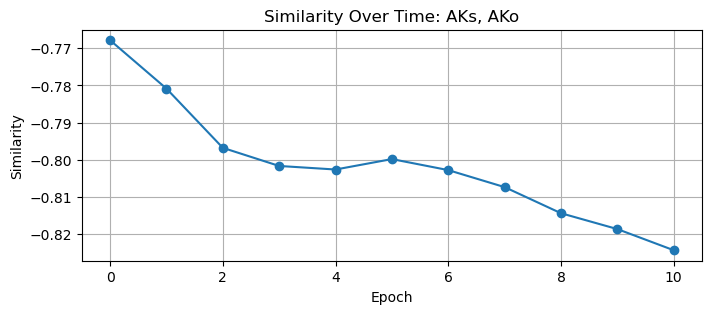

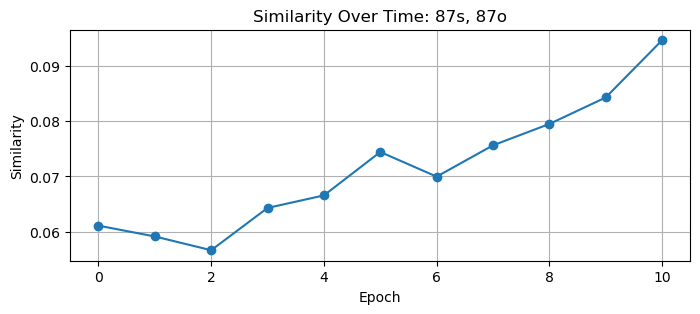

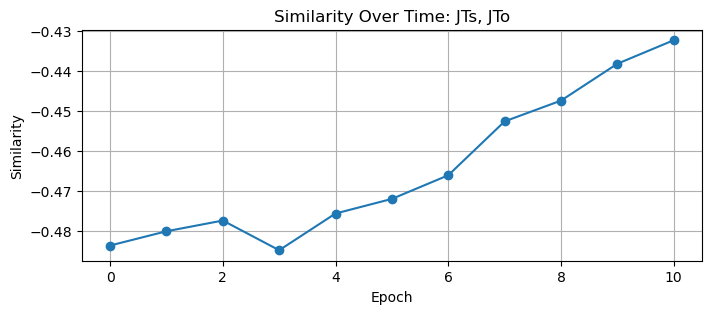

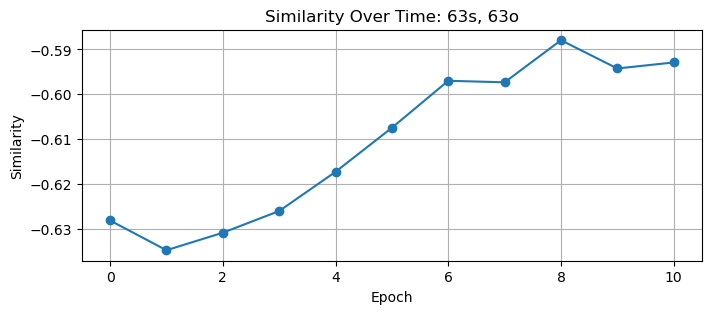

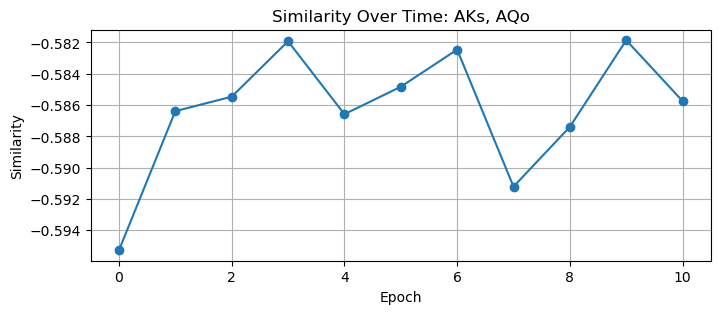

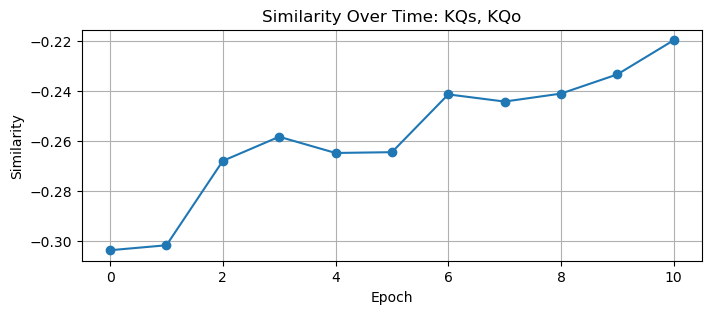

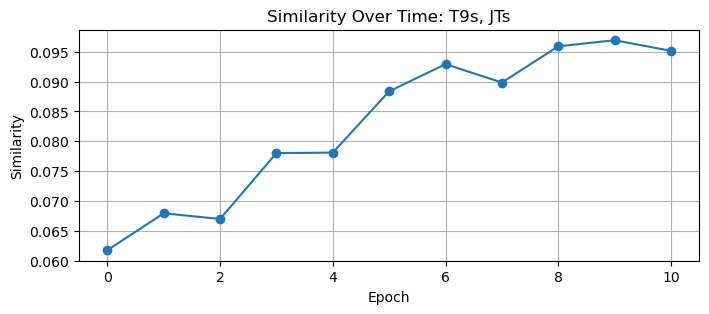

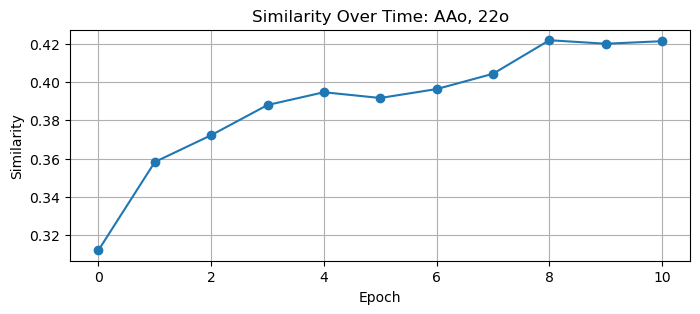

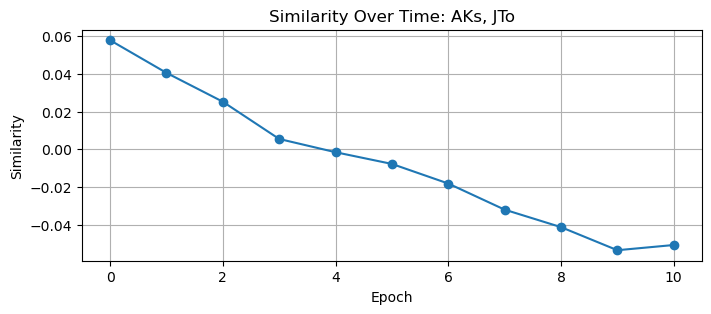

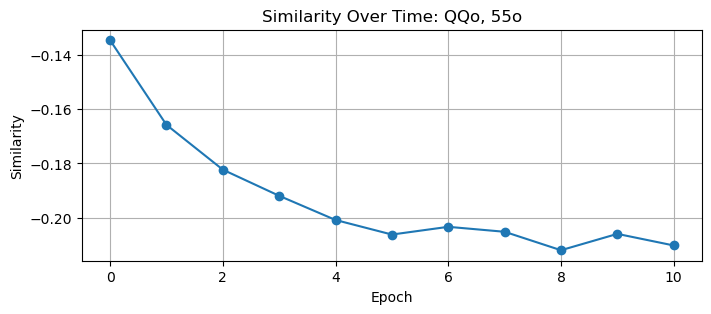

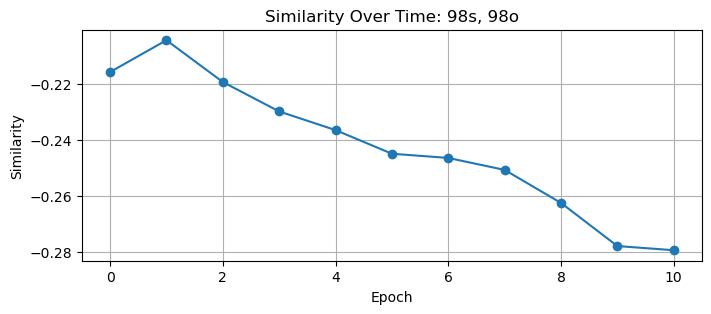

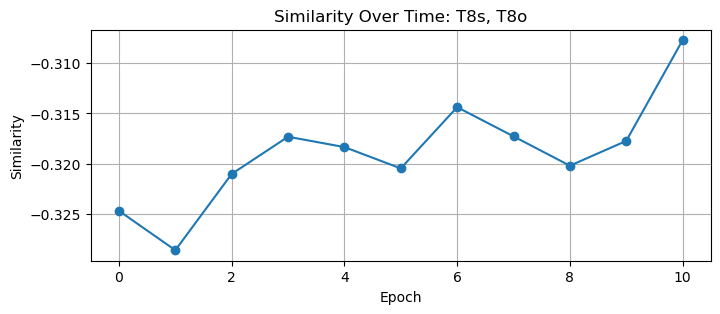

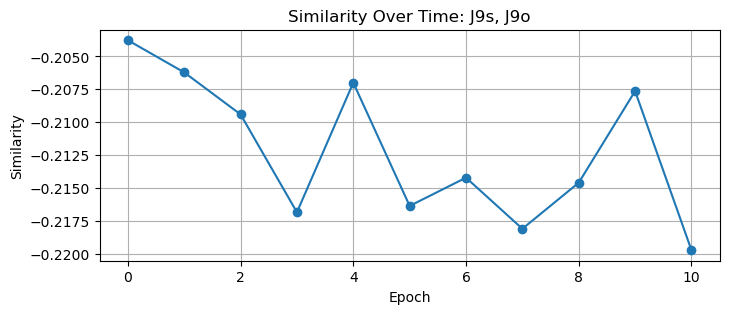

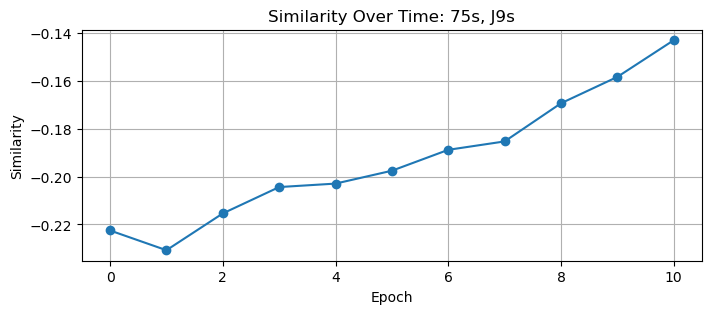

In [125]:
for i, j in test_hands:
    plot_simimilarity_time(i,j)